Based on the MetPy example ["Station Plot with Layout"](http://metpy.readthedocs.org/en/latest/examples/generated/Station_Plot_with_Layout.html)

In [3]:
import datetime
import pandas
import matplotlib.pyplot as plt
import numpy as np
import pprint
from awips.dataaccess import DataAccessLayer
from metpy.calc import get_wind_components
from metpy.cbook import get_test_data
from metpy.plots.wx_symbols import sky_cover, current_weather
from metpy.plots import StationPlot, StationPlotLayout, simple_layout
from metpy.units import units

def get_cloud_cover(code):
    if 'OVC' in code:
        return 1.0
    elif 'BKN' in code:
        return 6.0/8.0
    elif 'SCT' in code:
        return 4.0/8.0
    elif 'FEW' in code:
        return 2.0/8.0
    else:
        return 0

state_capital_wx_stations = {'Washington':'KOLM', 'Oregon':'KSLE', 'California':'KSAC',
                             'Nevada':'KCXP', 'Idaho':'KBOI', 'Montana':'KHLN',
                             'Utah':'KSLC', 'Arizona':'KDVT', 'New Mexico':'KSAF',
                             'Colorado':'KBKF', 'Wyoming':'KCYS', 'North Dakota':'KBIS',
                             'South Dakota':'KPIR', 'Nebraska':'KLNK', 'Kansas':'KTOP',
                             'Oklahoma':'KPWA', 'Texas':'KATT', 'Louisiana':'KBTR',
                             'Arkansas':'KLIT', 'Missouri':'KJEF', 'Iowa':'KDSM',
                             'Minnesota':'KSTP', 'Wisconsin':'KMSN', 'Illinois':'KSPI',
                             'Mississippi':'KHKS', 'Alabama':'KMGM', 'Nashville':'KBNA',
                             'Kentucky':'KFFT', 'Indiana':'KIND', 'Michigan':'KLAN',
                             'Ohio':'KCMH', 'Georgia':'KFTY', 'Florida':'KTLH',
                             'South Carolina':'KCUB', 'North Carolina':'KRDU',
                             'Virginia':'KRIC', 'West Virginia':'KCRW',
                             'Pennsylvania':'KCXY', 'New York':'KALB', 'Vermont':'KMPV',
                             'New Hampshire':'KCON', 'Maine':'KAUG', 'Massachusetts':'KBOS',
                             'Rhode Island':'KPVD', 'Connecticut':'KHFD', 'New Jersey':'KTTN',
                             'Delaware':'KDOV', 'Maryland':'KNAK'}
single_value_params = ["timeObs", "stationName", "longitude", "latitude", 
                       "temperature", "dewpoint", "windDir",
                       "windSpeed", "seaLevelPress"]
multi_value_params = ["presWeather", "skyCover", "skyLayerBase"]
all_params = single_value_params + multi_value_params
obs_dict = dict({all_params: [] for all_params in all_params})
pres_weather = []
sky_cov = []
sky_layer_base = []

In [4]:
from dynamicserialize.dstypes.com.raytheon.uf.common.time import TimeRange
from datetime import datetime, timedelta
lastHourDateTime = datetime.utcnow() - timedelta(hours = 1)
start = lastHourDateTime.strftime('%Y-%m-%d %H')
beginRange = datetime.strptime( start + ":00:00", "%Y-%m-%d %H:%M:%S")
endRange = datetime.strptime( start + ":59:59", "%Y-%m-%d %H:%M:%S")
timerange = TimeRange(beginRange, endRange)

In [5]:
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest()
request.setDatatype("obs")
request.setParameters(*(all_params))
request.setLocationNames(*(state_capital_wx_stations.values()))

In [6]:
response = DataAccessLayer.getGeometryData(request,timerange)
for ob in response:
    avail_params = ob.getParameters()
    if "presWeather" in avail_params:
        pres_weather.append(ob.getString("presWeather"))
    elif "skyCover" in avail_params and "skyLayerBase" in avail_params:
        sky_cov.append(ob.getString("skyCover"))
        sky_layer_base.append(ob.getNumber("skyLayerBase"))
    else:
        for param in single_value_params:
            if param in avail_params:
                if param == 'timeObs':
                    obs_dict[param].append(datetime.fromtimestamp(ob.getNumber(param)/1000.0))
                else:
                    try:
                        obs_dict[param].append(ob.getNumber(param))
                    except TypeError:
                        obs_dict[param].append(ob.getString(param))
            else:
                obs_dict[param].append(None)

        obs_dict['presWeather'].append(pres_weather);
        obs_dict['skyCover'].append(sky_cov);
        obs_dict['skyLayerBase'].append(sky_layer_base);
        pres_weather = []
        sky_cov = []
        sky_layer_base = []

We can now use pandas to retrieve desired subsets of our observations.

In this case, return the most recent observation for each station.

In [7]:
df = pandas.DataFrame(data=obs_dict, columns=all_params)
#sort rows with the newest first
df = df.sort_values(by='timeObs', ascending=False)
#group rows by station
groups = df.groupby('stationName')
#create a new DataFrame for the most recent values
df_recent = pandas.DataFrame(columns=all_params)
#retrieve the first entry for each group, which will
#be the most recent observation
for rid, station in groups:
    row = station.head(1)
    df_recent = pandas.concat([df_recent, row])

Convert DataFrame to something metpy-readable by 
attaching units and calculating derived values

In [8]:
data = dict()
data['stid'] = np.array(df_recent["stationName"])
data['latitude']  = np.array(df_recent['latitude'])
data['longitude'] = np.array(df_recent['longitude'])
data['air_temperature'] = np.array(df_recent['temperature'], dtype=float)* units.degC
data['dew_point'] = np.array(df_recent['dewpoint'], dtype=float)* units.degC
data['slp'] = np.array(df_recent['seaLevelPress'])* units('mbar')
u, v = get_wind_components(np.array(df_recent['windSpeed']) * units('knots'),
                           np.array(df_recent['windDir']) * units.degree)
data['eastward_wind'], data['northward_wind'] = u, v
data['cloud_frac'] = [int(get_cloud_cover(x)*8) for x in df_recent['skyCover']]

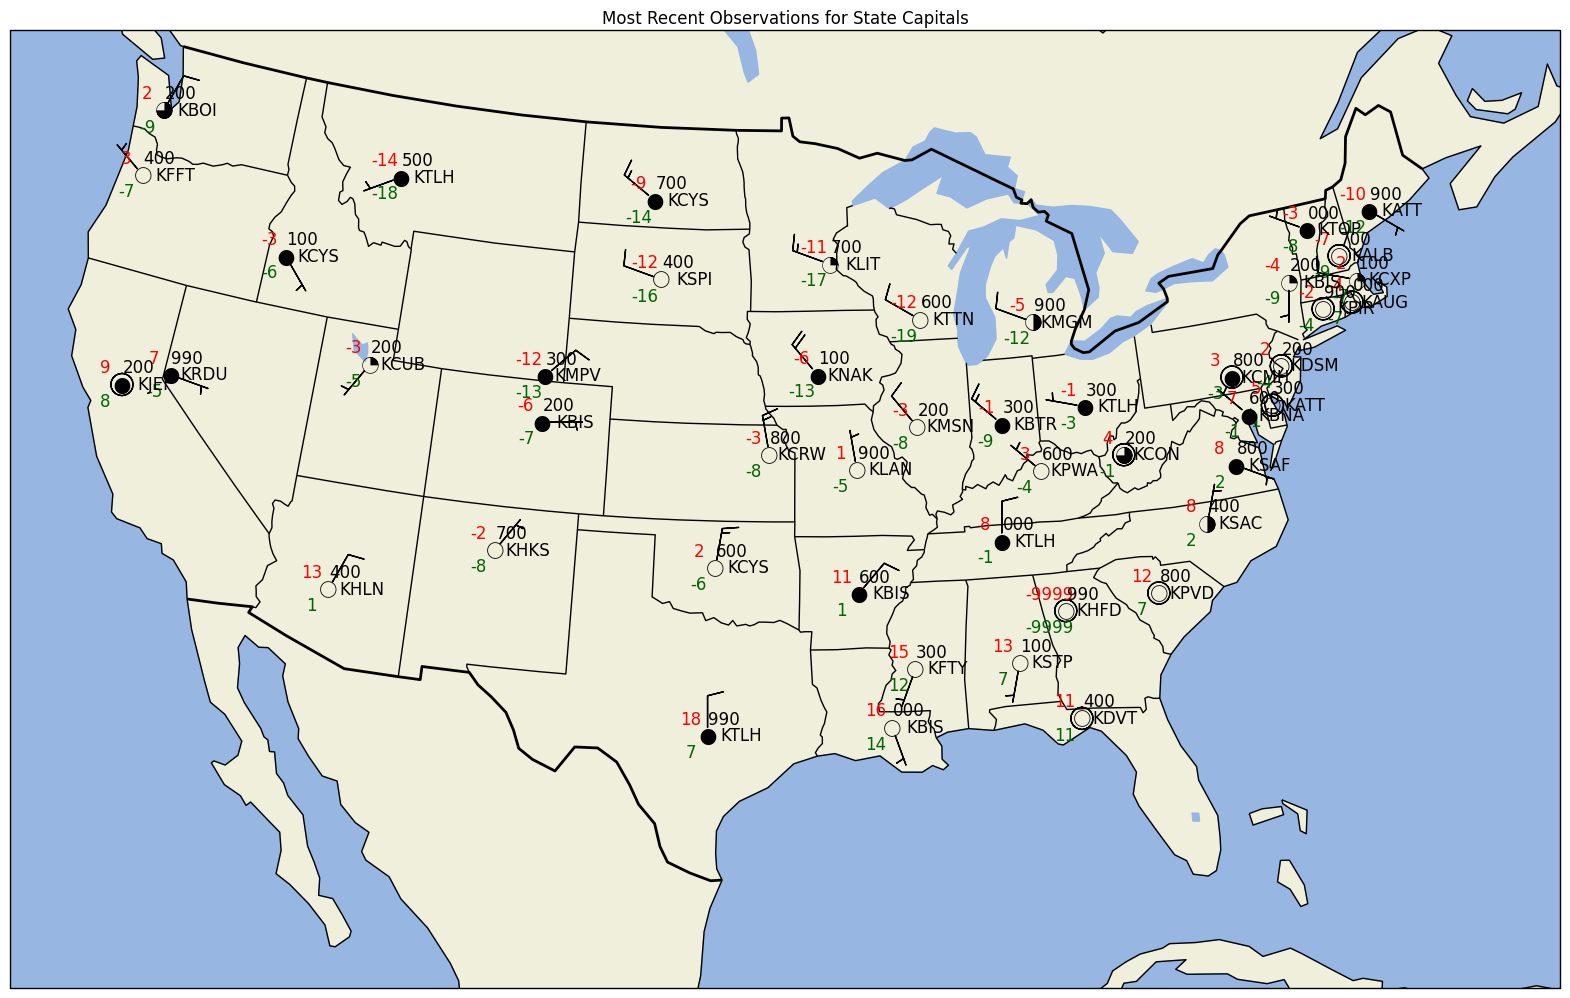

In [12]:
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as feat
from matplotlib import rcParams
rcParams['savefig.dpi'] = 100
proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35,
                             standard_parallels=[35])
state_boundaries = feat.NaturalEarthFeature(category='cultural',
                                            name='admin_1_states_provinces_lines',
                                            scale='110m', facecolor='none')
# Create the figure
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add map elements 
ax.add_feature(feat.LAND, zorder=-1)
ax.add_feature(feat.OCEAN, zorder=-1)
ax.add_feature(feat.LAKES, zorder=-1)
ax.coastlines(resolution='110m', zorder=2, color='black')
ax.add_feature(state_boundaries)
ax.add_feature(feat.BORDERS, linewidth='2', edgecolor='black')
ax.set_extent((-120, -70, 20, 50))

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also set the fontsize to 12 pt.
stationplot = StationPlot(ax, data['longitude'], data['latitude'],
                          transform=ccrs.PlateCarree(), fontsize=12)

# The layout knows where everything should go, and things are standardized using
# the names of variables. So the layout pulls arrays out of `data` and plots them
# using `stationplot`.
simple_layout.plot(stationplot, data)

# Plot the temperature and dew point to the upper and lower left, respectively, of
# the center point. Each one uses a different color.
stationplot.plot_parameter('NW', np.array(data['air_temperature']), color='red')
stationplot.plot_parameter('SW', np.array(data['dew_point']), color='darkgreen')

# A more complex example uses a custom formatter to control how the sea-level pressure
# values are plotted. This uses the standard trailing 3-digits of the pressure value
# in tenths of millibars.
stationplot.plot_parameter('NE', np.array(data['slp']),
                           formatter=lambda v: format(10 * v, '.0f')[-3:])

# Plot the cloud cover symbols in the center location. This uses the codes made above and
# uses the `sky_cover` mapper to convert these values to font codes for the
# weather symbol font.
stationplot.plot_symbol('C', data['cloud_frac'], sky_cover)

# Also plot the actual text of the station id. Instead of cardinal directions,
# plot further out by specifying a location of 2 increments in x and 0 in y.
stationplot.plot_text((2, 0), np.array(obs_dict["stationName"]))

plt.title("Most Recent Observations for State Capitals")